# Example of running and analysing the energy system model of the NL

In [1]:
import calliope
import pandas as pd

calliope.set_log_verbosity("INFO", include_solver_output=True)

# 1. Reference case
## 1.1. Create and solve the model

In [2]:
model = calliope.read_yaml('model/model.yaml')

[2025-11-10 17:18:21] INFO     Math init | loading pre-defined math.
[2025-11-10 17:18:21] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:18:22] INFO     Model: preprocessing data
[2025-11-10 17:18:22] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:22] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:22] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:22] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:22] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:22] INFO     Model: initialisation complete


In [3]:
model.inputs.sink_use_equals.to_series().dropna()

timesteps            nodes  techs       
2019-01-01 00:00:00  NLD    demand_power    11194.0
2019-01-01 01:00:00  NLD    demand_power    10933.0
2019-01-01 02:00:00  NLD    demand_power    10667.0
2019-01-01 03:00:00  NLD    demand_power    10413.0
2019-01-01 04:00:00  NLD    demand_power    10441.0
                                             ...   
2019-01-31 19:00:00  NLD    demand_power    16136.0
2019-01-31 20:00:00  NLD    demand_power    15205.0
2019-01-31 21:00:00  NLD    demand_power    14148.0
2019-01-31 22:00:00  NLD    demand_power    13304.0
2019-01-31 23:00:00  NLD    demand_power    12680.0
Name: sink_use_equals, Length: 744, dtype: float64

In [4]:
model.build()
model.solve()

[2025-11-10 17:18:22] INFO     Model: backend build starting
[2025-11-10 17:18:22] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:18:22] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:18:23] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:18:24] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:18:24] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:18:24] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:18:24] INFO     Model: backend build complete
[2025-11-10 17:18:24] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:18:25] DEBUG    Read LP format model from file /tmp/tmpnm0glf50.pyomo.lp
Reading time = 0.03 seconds
x1: 14876 rows, 8928 columns, 26032 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasib

## 1.2. Do a first sense-check of the results

In [5]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

,nodes,carriers,timesteps,system_balance
0,NLD,power,2019-01-01 00:00:00,0.007982
1,NLD,power,2019-01-01 01:00:00,0.007982
2,NLD,power,2019-01-01 02:00:00,0.007982
3,NLD,power,2019-01-01 03:00:00,0.007982
4,NLD,power,2019-01-01 04:00:00,0.007982


<Axes: >

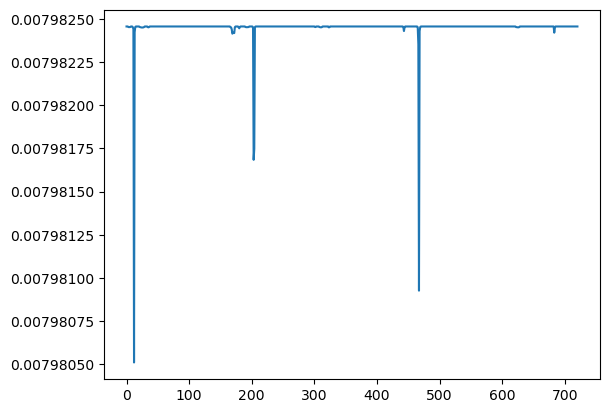

In [6]:
# Create a Date Range to select a few days in November to inspect visually
days_of_interest = pd.date_range('2019-01-01','2019-01-31',freq='h') 
# Plot the days of interest
balance_price['system_balance'].loc[balance_price['timesteps'].isin(days_of_interest)].plot()

Because the model is very simple, the price always matches the price of the CCGT unless renewables are capable of meeting demand by themselves. We can check that the value shown in the shadow price is indeed the marginal cost of the CCGT by performing a few steps. The marginal cost is, in fact, the ratio between the variable co

In [7]:
variable_costs = model.results.cost_operation_variable.to_series().dropna()
variable_costs.head()

nodes  techs  costs     timesteps          
NLD    ccgt   monetary  2019-01-01 00:00:00    49.090990
                        2019-01-01 01:00:00    44.644457
                        2019-01-01 02:00:00    39.875288
                        2019-01-01 03:00:00    33.536474
                        2019-01-01 04:00:00    31.476316
Name: cost_operation_variable, dtype: float64

In [8]:
generation = model.results.flow_out.to_series().dropna()
generation.head()

nodes  techs  carriers  timesteps          
NLD    ccgt   power     2019-01-01 00:00:00    6149.860308
                        2019-01-01 01:00:00    5592.822140
                        2019-01-01 02:00:00    4995.365735
                        2019-01-01 03:00:00    4201.272567
                        2019-01-01 04:00:00    3943.186885
Name: flow_out, dtype: float64

In [9]:
# If we calculate the marginal generation costs per generator type,
# we should see an equivalence between the shadow price in any given
# hour and the marginal cost of the marginal generator in the merit order
marginal_generation_costs = variable_costs/generation
marginal_generation_costs.head()

nodes  techs  costs     timesteps            carriers
NLD    ccgt   monetary  2019-01-01 00:00:00  power       0.007982
                        2019-01-01 01:00:00  power       0.007982
                        2019-01-01 02:00:00  power       0.007982
                        2019-01-01 03:00:00  power       0.007982
                        2019-01-01 04:00:00  power       0.007982
dtype: float64

As expected, the marginal cost of CCGT equals the shadow price. CCGT is the marginal generator in the merit order.

In [10]:
# To check the merit order, we may look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_operation_variable / model.results.flow_out
# We select a specific hour of the year
my_timestep = '2019-01-01 04:00:00'
# And we select only generators, excluding curtailment and other techs
gen_techs = ['solar_pv' ,'wind_offshore', 'wind_onshore', 'ccgt', 'nuclear'] 
# We can now inspect the marginal generation cost in that timestep
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', costs='monetary', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

nodes  techs        
NLD    solar_pv         0.000000
       wind_offshore    0.000000
       wind_onshore     0.001508
       ccgt             0.007982
       nuclear          0.022375
dtype: float64

We see that CCGT, whose marginal generation costs match the shadow price, is the marginal generator. Nuclear isn't used; if it were, the shadow price would be higher and equal to its marginal cost. This can be double-checked by looking at the dispatch plots.

## 1.3. Export the results for further analysis at any later moment

In [11]:
# It is helpful to store the model results as a whole in NetCDF format, which Calliope can import back
# at any later time. 
model.to_netcdf('results/default_results.nc')

In [12]:
# Alternatively, results can be exported as a series of .csv files for inspection and analysis in Excel or
# other software that may benefit from .csv data
model.to_csv('results/default_results_csv')

## 1.4. Produce some visualisations

In this example, we provide some pre-made plotting functionalities in the 'plotting_utilities.py' file, which you can import and apply as well as use as an example for making your own custom plots.

In [13]:
# Import some pre-made plotting functionalities as an example. You can use these, make your own, or simply
# create plots with your favourite Python library or non-Python tool, such as Excel
from plotting_utilities import plot_dispatch,plot_load_duration_curve

[2025-11-10 17:18:27] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:18:27] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:27] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:27] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:27] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:27] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:27] INFO     Model: initialisation complete


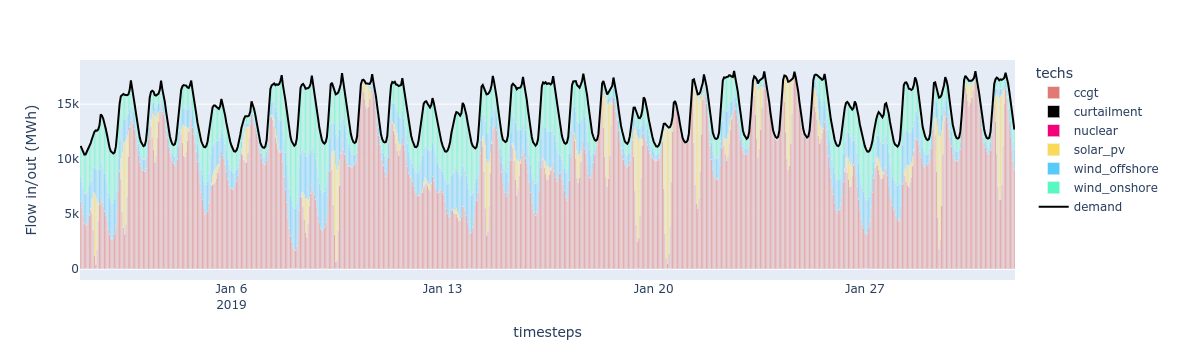

In [14]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/default_results.nc', plot_export_path='results/default_dispatch.html')

In [15]:
# For generating load duration curves (LDCs), instead, we first need to import back the model results,
# then extract the time-varing variable of interest
model = calliope.read_netcdf('results/default_results.nc')

[2025-11-10 17:18:29] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:18:29] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     Model: initialisation complete


In [16]:
# Suppose we want to plot the LDC of the dispatch of the CCGT power plant
ccgt_dispatch = model.results.flow_out.sel(techs='ccgt').to_series().dropna()
ccgt_dispatch.head()

nodes  carriers  timesteps          
NLD    power     2019-01-01 00:00:00    6149.860308
                 2019-01-01 01:00:00    5592.822140
                 2019-01-01 02:00:00    4995.365735
                 2019-01-01 03:00:00    4201.272567
                 2019-01-01 04:00:00    3943.186885
Name: flow_out, dtype: float64

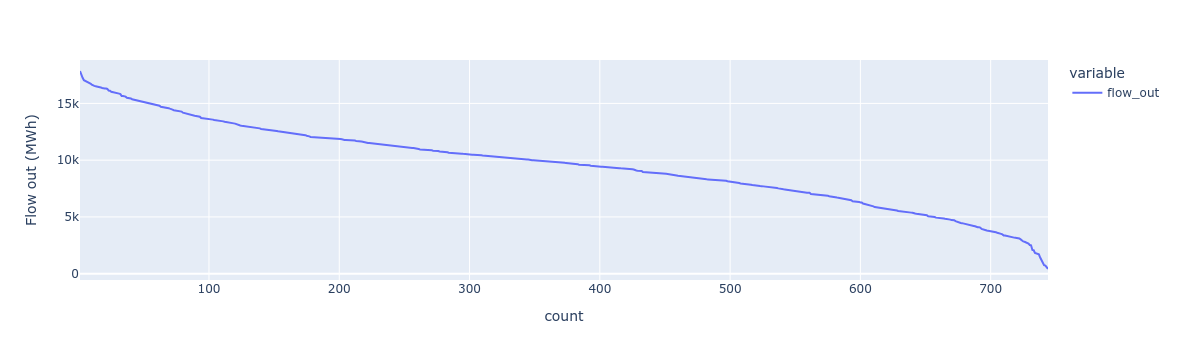

In [17]:
plot_load_duration_curve(dataframe=ccgt_dispatch.to_frame(), 
                         plot_export_path='results/default_ccgt_ldc.html', 
                         y_label='Flow out (MWh)')

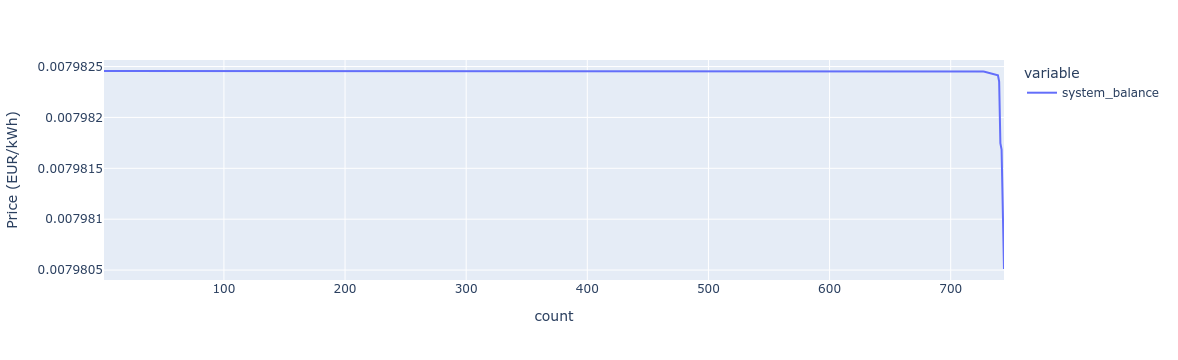

In [18]:
# Or we may want the LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

In [ ]:
# Obtain demand from input
demand = model.inputs.sink_use_equals.sel(techs='demand_power').to_series().dropna()

# Get the dispatch of renewables
solar_pv_dispatch = model.results.flow_out.sel(techs='solar_pv').to_series().dropna()
wind_onshore_dispatch = model.results.flow_out.sel(techs='wind_onshore').to_series().dropna()

# Calculate the residual load (load minus renewable generation)
residual_load = demand - (solar_pv_dispatch + wind_onshore_dispatch)
residual_load.head()

In [ ]:
# Plot the LDC of the residual load
plot_load_duration_curve(dataframe=residual_load.to_frame(name='Residual Load (MWh)'),
                         plot_export_path='results/default_residual_load.html',
                         y_label='Residual Load (MWh)')


# 2. Carbon tax case
## 2.1. Reload the model with a carbon tax scenario and re-solve

In [19]:
model = calliope.read_yaml('model/model.yaml',scenario='carbon_tax')

[2025-11-10 17:18:29] INFO     (scenarios, carbon_tax ) | Applying the following overrides: ['carbon_tax'].
[2025-11-10 17:18:29] INFO     Math init | loading pre-defined math.
[2025-11-10 17:18:29] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:18:29] INFO     Model: preprocessing data
[2025-11-10 17:18:29] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:29] INFO

In [20]:
model.build()
model.solve()

[2025-11-10 17:18:29] INFO     Model: backend build starting
[2025-11-10 17:18:30] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:18:30] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:18:30] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:18:32] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:18:32] INFO     Model: backend build complete
[2025-11-10 17:18:32] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:18:32] DEBUG    Read LP format model from file /tmp/tmpik4gym7h.pyomo.lp
Reading time = 0.03 seconds
x1: 14876 rows, 8928 columns, 26032 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasib

## 2.2. Analyse how prices and operation change

In [21]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

,nodes,carriers,timesteps,system_balance
0,NLD,power,2019-01-01 00:00:00,0.025526
1,NLD,power,2019-01-01 01:00:00,0.025526
2,NLD,power,2019-01-01 02:00:00,0.025526
3,NLD,power,2019-01-01 03:00:00,0.025526
4,NLD,power,2019-01-01 04:00:00,0.025526


We see that the shadow price changes and it is higher than in the default case, as expected.
We can visualise its LDC again:

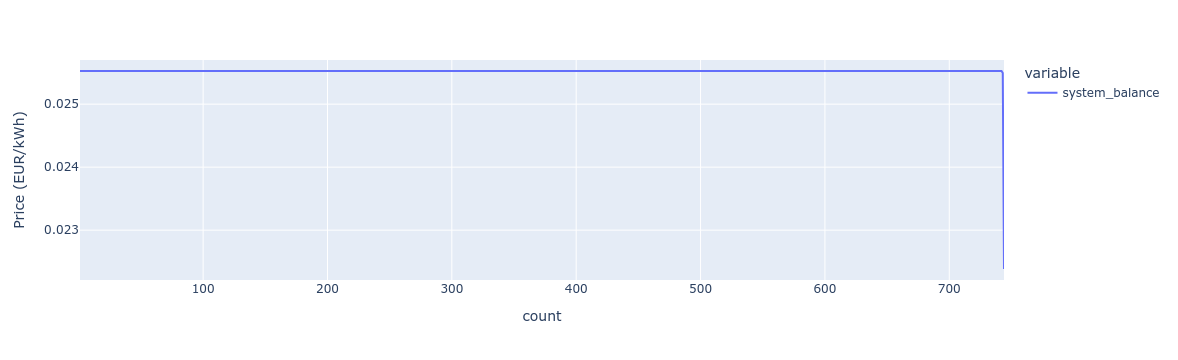

In [22]:
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

In [23]:
# To calculate the merit order, we want to look at a particular timestep
# and at the list of generators producing in that timestep in ascending cost order.
# The per-timestep selection is easier done before transforming to a Pandas series.
marginal_generation_costs_xr = model.results.cost_operation_variable / model.results.flow_out
my_timestep = '2019-01-01 04:00:00'
gen_techs = ['solar_pv' ,'wind_offshore', 'wind_onshore', 'ccgt', 'nuclear'] # We select only generators, excluding curtailment and other techs
marginal_generation_cost_in_timestep = marginal_generation_costs_xr.sel(timesteps=my_timestep, carriers='power', techs=gen_techs)
marginal_generation_cost_in_timestep.to_series().fillna(0).sort_values()

nodes  techs          costs   
NLD    solar_pv       co2         0.000000
                      monetary    0.000000
       wind_offshore  co2         0.000000
                      monetary    0.000000
       wind_onshore   co2         0.000000
       nuclear        co2         0.000000
       ccgt           co2         0.000351
       wind_onshore   monetary    0.001508
       ccgt           monetary    0.007982
       nuclear        monetary    0.022375
dtype: float64

We see that, in this case, the shadow price matches the marginal cost of the nuclear power plant. Nuclear is the marginal generator

In [24]:
model.to_netcdf('results/carbontax_results.nc')

As before, you may use the plotting utilities or your own custom code

[2025-11-10 17:23:23] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:23:23] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:23:23] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:23:23] INFO     Model: initialisation complete


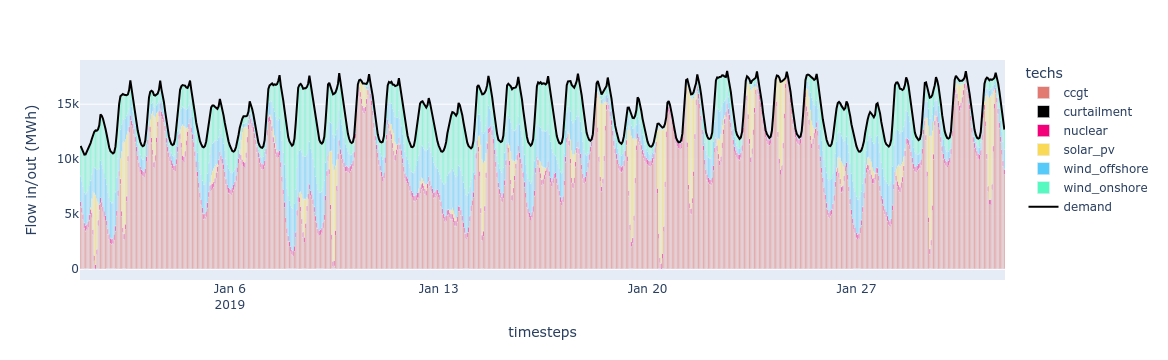

In [32]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/carbontax_results.nc', plot_export_path='results/carbontax_dispatch.html')

Note: The installed capacity of each power plant hasn't changed: nuclear was there in the default scenario, and it's here again, given that the system design is fixed and we only look at the dispatch. However, nuclear power is now in the dispatch, which wasn't the case before.
This is the effect of the carbon tax, which is making CCGT less attractive!

# 3. Renewables growth case
## 3.1. Reload the model with a scenario that forces a higher capacity of renewables and re-solve

In [26]:
model = calliope.read_yaml('model/model.yaml',scenario='more_renewables')

[2025-11-10 17:18:33] INFO     Loading overrides from scenario: more_renewables 
[2025-11-10 17:18:33] INFO     (scenarios, more_renewables ) | Applying the following overrides: ['higher_solar', 'higher_wind'].
[2025-11-10 17:18:33] INFO     Math init | loading pre-defined math.
[2025-11-10 17:18:33] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:18:33] INFO     Model: preprocessing data
[2025-11-10 17:18:33] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:18:34] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:18:34] INFO     input data `name` not 

In [27]:
model.build()
model.solve()

[2025-11-10 17:18:34] INFO     Model: backend build starting
[2025-11-10 17:18:34] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:18:34] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:18:35] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:18:36] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:18:36] INFO     Model: backend build complete
[2025-11-10 17:18:37] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:18:37] DEBUG    Read LP format model from file /tmp/tmpicbhlh16.pyomo.lp
Reading time = 0.02 seconds
x1: 14876 rows, 8928 columns, 26032 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasib

In [28]:
model.to_netcdf('results/more_vres.nc')

## 3.1. Visualise the change in the system operation and the impact on prices

[2025-11-10 17:24:39] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:24:39] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:24:39] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:24:39] INFO     Model: initialisation complete


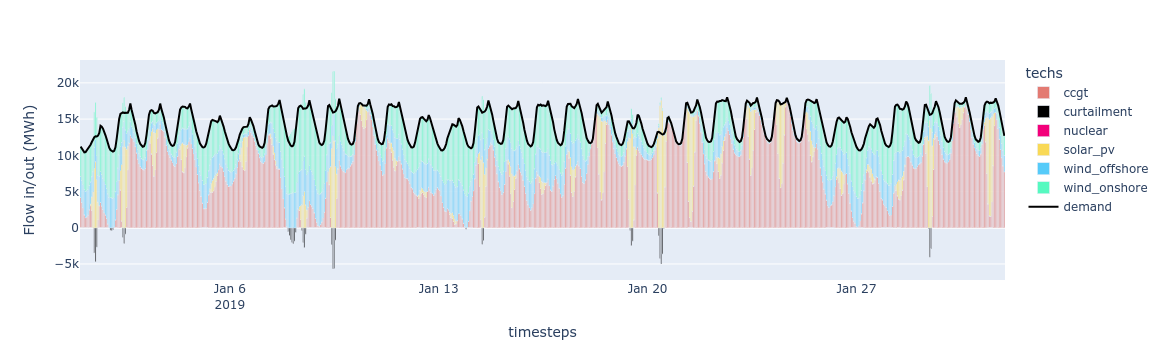

In [33]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/more_vres.nc', plot_export_path='results/more_vres.html')

In [30]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

,nodes,carriers,timesteps,system_balance
0,NLD,power,2019-01-01 00:00:00,0.007982
1,NLD,power,2019-01-01 01:00:00,0.007982
2,NLD,power,2019-01-01 02:00:00,0.007982
3,NLD,power,2019-01-01 03:00:00,0.007982
4,NLD,power,2019-01-01 04:00:00,0.007982


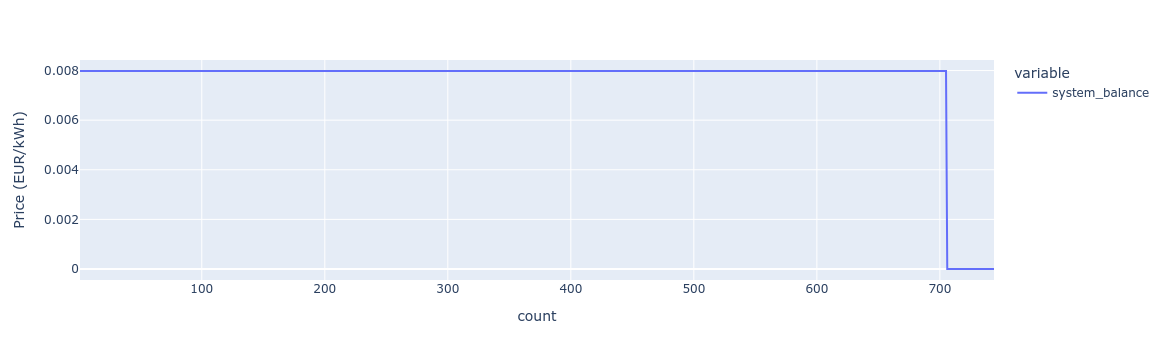

In [31]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')

# 4. Generation capacity outage case
## 4.1 Reload the model with a scenario that forces a lower capacity of CCGT and re-solve

In [54]:
model = calliope.read_yaml('model/model.yaml',scenario='generation_outage')

[2025-11-10 17:38:31] INFO     Loading overrides from scenario: generation_outage 
[2025-11-10 17:38:31] INFO     (scenarios, generation_outage ) | Applying the following overrides: ['lower_ccgt'].
[2025-11-10 17:38:31] INFO     Math init | loading pre-defined math.
[2025-11-10 17:38:31] INFO     Math init | loading math files {'operate', 'base', 'storage_inter_cluster', 'milp', 'spores'}.
[2025-11-10 17:38:31] INFO     Model: preprocessing data
[2025-11-10 17:38:31] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:32] INFO     input data `name` not defined in mo

In [55]:
model.build()
model.solve()

[2025-11-10 17:38:32] INFO     Model: backend build starting
[2025-11-10 17:38:32] INFO     Optimisation Model | parameters/lookups | Generated.
[2025-11-10 17:38:32] INFO     Optimisation Model | variables | Generated.
[2025-11-10 17:38:33] INFO     Optimisation Model | global_expressions | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | piecewise_constraints | Generated.
[2025-11-10 17:38:34] INFO     Optimisation Model | objectives | Generated.
[2025-11-10 17:38:34] INFO     Model: backend build complete
[2025-11-10 17:38:34] INFO     Optimisation model | starting model in base mode.
[2025-11-10 17:38:35] DEBUG    Read LP format model from file /tmp/tmp_383qm9w.pyomo.lp
Reading time = 0.02 seconds
x1: 15620 rows, 10416 columns, 28264 nonzeros
Set parameter QCPDual to value 1
Set parameter Threads to value 6
Set parameter Method to value 2
Set parameter Crossover to value 0
Set parameter Feasi

In [56]:
model.to_netcdf('results/less_generation.nc')

## 4.1. Visualise the change in the system operation and the impact on prices

[2025-11-10 17:38:36] INFO     Model: preprocessing data (reentry)
[2025-11-10 17:38:36] INFO     Math build | building applied math with ['base', 'operate'].
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `color` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     input data `name` not defined in model math; it will not be available in the optimisation problem.
[2025-11-10 17:38:36] INFO     Model: initialisation complete


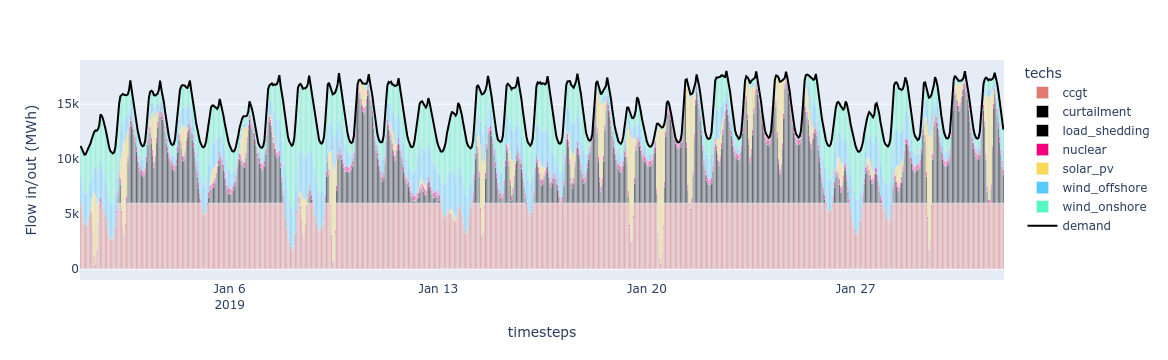

In [57]:
# Dispatch plots can be generated directly from the saved model results
plot_dispatch(model_path='results/less_generation.nc', plot_export_path='results/less_generation.html')

In [58]:
# Shadow price for the power system balance constraint
balance_price = model.backend.shadow_prices.get("system_balance").to_series().reset_index()
balance_price.head()

,nodes,carriers,timesteps,system_balance
0,NLD,power,2019-01-01 00:00:00,0.022375
1,NLD,power,2019-01-01 01:00:00,0.007982
2,NLD,power,2019-01-01 02:00:00,0.007982
3,NLD,power,2019-01-01 03:00:00,0.007982
4,NLD,power,2019-01-01 04:00:00,0.007982


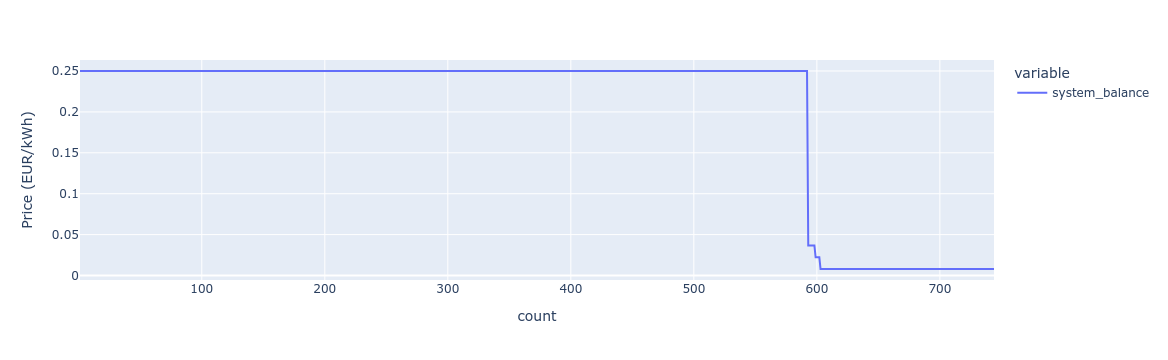

In [59]:
# LDC of the shadow price, which we calculated earlier
plot_load_duration_curve(dataframe=balance_price['system_balance'].to_frame(), 
                         plot_export_path='results/default_price.html', 
                         y_label='Price (EUR/kWh)')